In [1]:
import os
import scipy.io
import random
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os, sys, traceback, getpass, time, re

In [134]:
def calculate_stat(mat, subject, feature_len):
    means = []
    stds = []
    for i in range(feature_len):
        a = []
        for j in range(len(mat[0][subject])): #clip
            a.append(mat[0][subject][j][-feature_len + i])
        a = np.nan_to_num(a)
        means.append(np.mean(a, axis=0))
        stds.append(np.std(a, axis=0))
    return means, stds

def standarize_and_clamp(arr, mean, std):
    arr = (arr - mean)/std
    arr = np.clip(arr, -1, 1)
    return arr

def normalize(arr):
    arr = (arr - np.min(arr))/(np.max(arr) - np.min(arr))
    return arr

def get_arousal_class(rate, mean):
    if rate < mean:
        return '-1'
    else:
        return '+1'

def get_valence_class(rate, mean):
    if rate < mean:
        return '-1'
    else:
        return '+1'

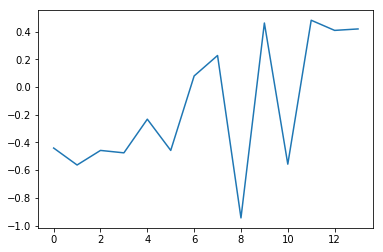

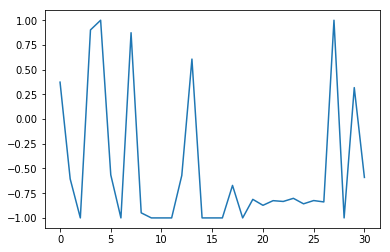

C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:102: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


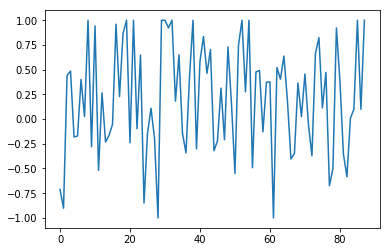

In [3]:
features = {'ECG':[], 'GSR':[], 'EEG':[], 'ResNet':[] }

# ECG feature
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_ECGFeatures.mat')
mat = mat['ECGFeatures_58']
mat = np.nan_to_num(mat)
tmp_mat = np.zeros((1, 58, 36, 14))
for i in range(len(mat[0])): # subject
    means, stds = calculate_stat(mat, subject=i, feature_len=14)
    for j in range(len(mat[0][i])): # clip
        for k in range(len(mat[0][i][j][18:])): # feature
            tmp_mat[0][i][j][k] = standarize_and_clamp(mat[0][i][j][-14+k], means[k], stds[k])
mat = tmp_mat
features['ECG'] = mat
plt.plot([x for x in range(len(features['ECG'][0][0][33]))], features['ECG'][0][0][33])
plt.show()


# GSR feature
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_GSRFeatures.mat')
mat = mat['GSRFeatures_58']
mat = np.nan_to_num(mat)
tmp_mat = np.zeros((1, 58, 36, 31))
for i in range(len(mat[0])): # subject
    means, stds = calculate_stat(mat, subject=i,feature_len=31)
    for j in range(len(mat[0][i])): # clip
        for k in range(31):
            tmp_mat[0][i][j][k] = standarize_and_clamp(mat[0][i][j][k], means[k], stds[k])
mat = tmp_mat
features['GSR'] = mat
plt.plot([x for x in range(len(features['GSR'][0][0][33]))], features['GSR'][0][0][33])
plt.show()


# EEG feature
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_EEGFeatures.mat')
mat = mat['EEGFeatures_58']
mat = np.nan_to_num(mat)
tmp_mat = np.zeros((1, 58, 36, 88))
for i in range(len(mat[0])): # subject
    means, stds = calculate_stat(mat, subject=i, feature_len=88)
    for j in range(len(mat[0][i])): # clip
        for k in range(88): # feature
            tmp_mat[0][i][j][k] = standarize_and_clamp(mat[0][i][j][k], means[k], stds[k])
mat = tmp_mat
features['EEG'] = mat
plt.plot([x for x in range(len(features['EEG'][0][0][33]))], features['EEG'][0][0][33])
plt.show()

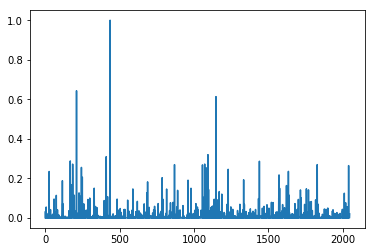

In [7]:
# ResNet EEG feature
data = np.load('EEG_ResNet_Features.npz')
data = data['features']
for i in range(2088):
    data[i][0] = normalize(data[i][0])
features['ResNet'] = data
plt.plot([x for x in range(2048)], features['ResNet'][33][0])

In [104]:
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_Order_Movie.mat')
order = mat['PermutationList']
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_SelfReports.mat')
rating = mat['Ratings']

features['ECG'] = np.nan_to_num(features['ECG'])
features['GSR'] = np.nan_to_num(features['GSR'])
features['EEG'] = np.nan_to_num(features['EEG'])
features['ResNet'] = np.nan_to_num(features['ResNet'])

#clusters = [0, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 2, 1, 0,
 #2, 0, 2, 2, 2, 2, 0, 1, 2, 1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0]

clusters = [2, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 1, 0, 2, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0,
 1, 2, 2, 0, 2, 1, 2, 0, 0, 1]

f = open('svmlib_dataset/train_subjects_id.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
train_subjects_list = np.array(rows).astype(int)
f.close()
train_subjects_list -= 1

test_subjects_list = np.array([2, 21, 22, 24, 25, 27, 28, 31, 32, 42, 49])

f = open('svmlib_dataset/features_permutation.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
feature_sequence = np.array(rows).astype(int)
f.close()

f = open('svmlib_dataset/samples_permutation_clip_wise.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
train_sample_sequence = np.array(rows).astype(int)
f.close()

f = open('svmlib_dataset/train_clips_id.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
train_clips_list = np.array(rows).astype(int)
f.close()

f = open('svmlib_dataset/selected_feature.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
selected_feature = np.array(rows).astype(int)
selected_feature -= 1
f.close()

'''
0 ~ 13: ECG
14 ~ 44: GSR
45 ~ 132: EEG
'''
ecgs = []
gsrs = []
eegs = []

# dataset for arousal classifier feature selection
subjects = 58
instances = 2088
clips = 36
ones = 0
zeros = 0
txts_train = []

ys = []
for i in range(58):
    for clip_index in range(33):
        #if(clip_index in train_clips_list): continue
#         if (i*36 + clip_index) not in train_sample_sequence:
#             continue
        feature_index = 0
        txt = ''
        txt += get_valence_class(rating[1][i][order[i][clip_index]-1]) # label
        ys.append([int(get_arousal_class(rating[0][i][order[i][clip_index]-1])), int(get_valence_class(rating[1][i][order[i][clip_index]-1]))])
        true_feature_index = 0
        #print(get_arousal_class(rating[0][i][order[i][clip_index]-1]))
        if get_valence_class(rating[1][i][order[i][clip_index]-1])=='+1':
            ones += 1
        else:
            zeros += 1
        feature_seq = []
        
        tmp = []
        # ECG
        for j in range(14):
            tmp.append(features['ECG'][0][i][clip_index][j])
        ecgs.append(tmp)
        tmp = [tmp]
        #tmptmp = pca_ecg.transform(tmp)
        tmptmp = tmp
        for ecg in tmptmp[0]:
            feature_seq.append(ecg)
        
        
        tmp = []
        # GSR
        for j in range(31):
            tmp.append(features['GSR'][0][i][clip_index][j])
        gsrs.append(tmp)
        tmp = [tmp]
        #tmptmp = pca_gsr.transform(tmp)
        tmptmp = tmp
        for gsr in tmptmp[0]:
            feature_seq.append(gsr)
            
        tmp = []
        # EEG
        for j in range(88):
            tmp.append(features['EEG'][0][i][clip_index][j])
        eegs.append(tmp)
        tmp = [tmp]
        #tmptmp = pca_eeg.transform(tmp)
        tmptmp = tmp
        for eeg in tmptmp[0]:
            feature_seq.append(eeg)
        
        
#         f = [0.0]*133
#         for j in range(len(feature_sequence)):
#             f[j] = feature_seq[feature_sequence[j]]
        
        random.shuffle(feature_seq)
        for j in range(len(feature_seq)): # selected_feature
            txt += ' '
            txt += str(feature_index+1) + ':' + str(feature_seq[j])
            feature_index += 1    
            
        txt += '\n'
    
        txts_train.append(txt)
        
random.shuffle(txts_train)
        
#print(zeros/(ones + zeros))
# f = open('svmlib_dataset/valence_train_sample_wise_pca', "w+")
# for i in range(1671): # len(train_sample_sequence) len(txts_train)
#     f.write(txts_train[i]) # txts_train[train_sample_sequence[i]] # txts_train[i]

# f.close()

# f = open('svmlib_dataset/valence_test_sample_wise_pca', "w+")
# for i in range(1671, 2088): # len(train_sample_sequence) len(txts_train)
#     f.write(txts_train[i]) # txts_train[train_sample_sequence[i]] # txts_train[i]

# f.close()

In [12]:
# k means svm
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_Order_Movie.mat')
order = mat['PermutationList']
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_SelfReports.mat')
rating = mat['Ratings']

features['ECG'] = np.nan_to_num(features['ECG'])
features['GSR'] = np.nan_to_num(features['GSR'])
features['EEG'] = np.nan_to_num(features['EEG'])
features['ResNet'] = np.nan_to_num(features['ResNet'])

clusters = [2, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 1, 0, 2, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0,
 1, 2, 2, 0, 2, 1, 2, 0, 0, 1]

f = open('svmlib_dataset/train_subjects_id.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
train_subjects_list = np.array(rows).astype(int)
f.close()
train_subjects_list -= 1

test_subjects_list = np.array([2, 21, 22, 24, 25, 27, 28, 31, 32, 42, 49])

f = open('svmlib_dataset/features_permutation.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
feature_sequence = np.array(rows).astype(int)
f.close()

f = open('svmlib_dataset/samples_permutation_clip_wise.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
train_sample_sequence = np.array(rows).astype(int)
f.close()
print(train_sample_sequence)

# f = open('svmlib_dataset/train_subjects_id.csv')
# rows = csv.reader(f)
# for row in rows:
#     rows = row
#     break
# train_subjects_list = np.array(rows).astype(int)
# f.close()

f = open('svmlib_dataset/selected_feature.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
selected_feature = np.array(rows).astype(int)
selected_feature -= 1
f.close()

'''
0 ~ 13: ECG
14 ~ 44: GSR
45 ~ 132: EEG
'''

# dataset for arousal classifier feature selection
subjects = 47
instances = 2088
clips = 36
ones = 0
zeros = 0


for k in range(3):
    txts_train = []
    index_1 = 0
    for i in train_subjects_list:
        #print(index_1, clusters[index_1], k)
        if clusters[index_1] != k:
            index_1 += 1
            continue
        for clip_index in range(36):
            #if(clip_index in train_clips_list): continue
            feature_index = 0
            txt = ''
            txt += get_valence_class(rating[1][i][order[i][clip_index]-1]) # label
            true_feature_index = 0

            if get_arousal_class(rating[1][i][order[i][clip_index]-1])=='+1':
                ones += 1
            else:
                zeros += 1
            feature_seq = []

            # ECG
            for j in range(14):
                feature_seq.append(features['ECG'][0][i][clip_index][j])

            # GSR
            for j in range(31):
                feature_seq.append(features['GSR'][0][i][clip_index][j])

            # EEG
            for j in range(88):
                feature_seq.append(features['EEG'][0][i][clip_index][j])


            f = [0.0]*133
            for j in range(len(feature_sequence)):
                f[j] = feature_seq[feature_sequence[j]]

            for j in range(133): # selected_feature
                txt += ' '
                txt += str(feature_index+1) + ':' + str(f[j])
                feature_index += 1    

            txt += '\n'

            txts_train.append(txt)
            
        index_1 += 1
    print(len(txts_train))
    random.shuffle(txts_train)

    f = open('svmlib_dataset/valence_train_' + str(k+1) + '_cluster', "w+")
    for i in range(len(txts_train)): # len(train_sample_sequence) len(txts_train)
        f.write(txts_train[i]) # txts_train[train_sample_sequence[i]] # txts_train[i]

    f.close()

[ 856 1568 1012 ...  992  396 1029]
504
468
720


In [7]:
# single subject
# k means svm
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_Order_Movie.mat')
order = mat['PermutationList']
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_SelfReports.mat')
rating = mat['Ratings']

features['ECG'] = np.nan_to_num(features['ECG'])
features['GSR'] = np.nan_to_num(features['GSR'])
features['EEG'] = np.nan_to_num(features['EEG'])
features['ResNet'] = np.nan_to_num(features['ResNet'])

clusters = [2, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 1, 0, 2, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0,
 1, 2, 2, 0, 2, 1, 2, 0, 0, 1]

f = open('svmlib_dataset/train_subjects_id.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
train_subjects_list = np.array(rows).astype(int)
f.close()
train_subjects_list -= 1

test_subjects_list = np.array([2, 21, 22, 24, 25, 27, 28, 31, 32, 42, 49])

f = open('svmlib_dataset/features_permutation.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
feature_sequence = np.array(rows).astype(int)
f.close()

f = open('svmlib_dataset/samples_permutation_clip_wise.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
train_sample_sequence = np.array(rows).astype(int)
f.close()
print(train_sample_sequence)

# f = open('svmlib_dataset/train_subjects_id.csv')
# rows = csv.reader(f)
# for row in rows:
#     rows = row
#     break
# train_subjects_list = np.array(rows).astype(int)
# f.close()

f = open('svmlib_dataset/selected_feature.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
selected_feature = np.array(rows).astype(int)
selected_feature -= 1
f.close()

'''
0 ~ 13: ECG
14 ~ 44: GSR
45 ~ 132: EEG
'''

# dataset for arousal classifier feature selection
subjects = 47
instances = 2088
clips = 36
ones = 0
zeros = 0


for k in range(1):
    
    
    for i in test_subjects_list:
        txts_test = []
        index_1 = 0
        for clip_index in range(36):
            feature_index = 0
            txt = ''
            txt += get_valence_class(rating[1][i][order[i][clip_index]-1]) # label
            true_feature_index = 0

            if get_arousal_class(rating[1][i][order[i][clip_index]-1])=='+1':
                ones += 1
            else:
                zeros += 1
            feature_seq = []

            # ECG
            for j in range(14):
                feature_seq.append(features['ECG'][0][i][clip_index][j])

            # GSR
            for j in range(31):
                feature_seq.append(features['GSR'][0][i][clip_index][j])

            # EEG
            for j in range(88):
                feature_seq.append(features['EEG'][0][i][clip_index][j])


            f = [0.0]*133
            for j in range(len(feature_sequence)):
                f[j] = feature_seq[feature_sequence[j]]

            for j in range(133): # selected_feature
                txt += ' '
                txt += str(feature_index+1) + ':' + str(f[j])
                feature_index += 1    

            txt += '\n'

            txts_test.append(txt)
            
        index_1 += 1
        random.shuffle(txts_test)

        f = open('svmlib_dataset/subjects/valence_test_' + str(i) + '_subject', "w+")
        for i in range(len(txts_test)): # len(train_sample_sequence) len(txts_train)
            f.write(txts_test[i]) # txts_train[train_sample_sequence[i]] # txts_train[i]

        f.close()

[ 856 1568 1012 ...  992  396 1029]


In [89]:
f = open('svmlib_dataset/arousal_test_sample_wise', "w+")
for i in range(1671, 2087):
    f.write(txts_train[i])
f.close()

In [ ]:
'''
to do lists:

* subject-wise split >
* clip-wise split >
* sample-wise split

* selected no-resnet >
* selected resnet-only
* no-personality
* with personality

* sample a subject of samples for IBCGA (for training and evaluating)

* get rid of neural rating
* MMAE

* k-means with personality

'''

In [6]:
# cmd
! pip install csv

  Could not find a version that satisfies the requirement csv (from versions: )
No matching distribution found for csv
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [75]:
rating[0][0][order[0][clip_index]-1]

4.0

In [106]:
f = open('./svmlib_dataset/arousal_test_sample_wise')
data = f.read()
f.close()

predicts = []
f = open('./libsvm-3.23/windows/tmp')
n = f.read()
n = n.split('\n')[1:]
for x in n:
    if x == '': break
    xx = x.split()
    predicts.append(float(xx[1]))
print(len(predicts))
data = data.split('\n')
positive = 0
right = 0
trues = []
for d in data:
    for s in d.split():
        if s[0] == '+':
            trues.append(1)
        else:
            trues.append(-1)
        break
print(len(trues))
fpr, tpr, _ = roc_curve(trues, predicts)
print(auc(fpr, tpr))

416
416
0.5563538689531068


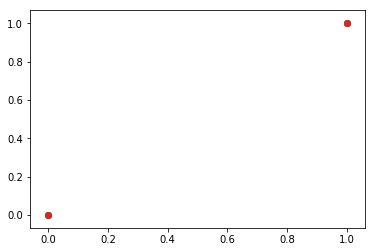

In [118]:
plt.scatter([0, 1], [0, 1])
plt.scatter([0, 1], [0, 1])
plt.scatter([0, 1], [0, 1])
plt.scatter([0, 1], [0, 1])
plt.savefig('gg')

In [123]:
def _aa():
    if _aa is not None:
        print('k')
    elif _aa is not None:
        print('k')
    else:
        print('k')
_aa()

k


[2 0 1 2 2 2 2 2 1 1 1 0 0 0 2 2 1 2 1 1 0 1 0 2 1 0 0 1 2 2 2 2 2 2 0 0 0
 1 2 2 0 2 1 2 0 0 1]
[0.2413793103448276, 0.22413793103448276, 0.3448275862068966]
[[4.5, 5.3, 3.7], [5.1, 6.0, 4.9], [2.8, 3.5, 2.5], [4.9, 4.7, 2.5], [5.5, 5.0, 4.3], [5.9, 3.9, 3.0], [5.7, 4.8, 4.5], [5.9, 4.9, 5.0], [3.0, 4.3, 3.7], [2.6, 5.7, 3.3], [4.1, 3.9, 3.8], [4.5, 4.5, 4.8], [3.9, 5.7, 4.1], [4.2, 5.6, 4.9], [5.1, 5.1, 3.5], [5.8, 6.9, 4.8], [3.0, 6.1, 2.7], [4.9, 5.9, 4.0], [3.1, 3.4, 4.1], [3.5, 5.4, 3.9], [4.6, 5.1, 4.6], [3.1, 4.6, 4.4], [3.2, 6.1, 5.7], [4.8, 5.4, 3.8], [3.0, 5.9, 3.8], [5.2, 6.4, 5.4], [3.9, 5.4, 4.3], [2.6, 4.2, 2.8], [5.6, 6.5, 2.6], [6.2, 4.8, 4.7], [5.1, 4.8, 3.3], [5.6, 6.0, 4.4], [5.5, 4.5, 3.8], [5.4, 5.6, 4.6], [3.9, 6.3, 4.4], [3.3, 5.8, 5.7], [3.6, 5.5, 5.0], [2.9, 4.0, 4.1], [5.4, 5.2, 5.1], [5.3, 5.2, 3.4], [2.9, 5.6, 5.7], [6.1, 5.3, 2.0], [4.1, 4.3, 2.7], [5.6, 5.7, 4.0], [3.2, 5.2, 5.5], [4.6, 5.4, 5.2], [4.0, 5.0, 4.0]]


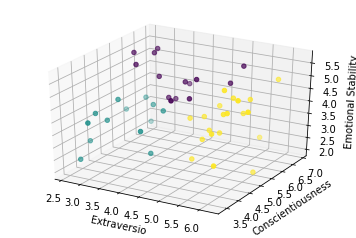

In [4]:
# personality k-means clustering
train_subjects_num = 47

clusters = 3
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_Personality.mat')
mat = mat['Personality']
personality = np.array([[0.0]*3]*train_subjects_num)
selected_personality = [0, 2, 3]

f = open('svmlib_dataset/train_subjects_id.csv')
rows = csv.reader(f)
for row in rows:
    rows = row
    break
train_subjects_list = np.array(rows).astype(int)
train_subjects_list -= 1
f.close()

index = 0
for i in train_subjects_list:
    for j in range(len(selected_personality)):
        personality[index][j] = mat[i][selected_personality[j]]
    index += 1

kmeans = KMeans(n_clusters=clusters, random_state=0).fit(personality)
print(np.array(kmeans.labels_))
distributions = []
for i in range(clusters):
    distributions.append(sum([1 if x == i else 0 for x in kmeans.labels_])/mat.shape[0])
print(distributions)
print(personality.tolist())
ax = plt.axes(projection='3d')
ax.scatter(xs=personality[:, 0], ys=personality[:, 1], zs=personality[:, 2], c=kmeans.labels_)
ax.set_xlabel("Extraversio")
ax.set_ylabel("Conscientiousness")
ax.set_zlabel("Emotional Stability")
plt.savefig('personality_train_k_means')

In [9]:
# mmae
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_Order_Movie.mat')
order = mat['PermutationList']
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_SelfReports.mat')
rating = mat['Ratings']

features['ECG'] = np.nan_to_num(features['ECG'])
features['GSR'] = np.nan_to_num(features['GSR'])
features['EEG'] = np.nan_to_num(features['EEG'])
features['ResNet'] = np.nan_to_num(features['ResNet'])

ecgs = []
gsrs = []
eegs = []

# dataset for arousal classifier feature selection
subjects = 58
instances = 2088
clips = 36
ones = 0
zeros = 0


mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_Personality.mat')
mat = mat['Personality']
personality = np.array([[0.0]*3]*58)
selected_personality = [0, 2, 3]

for i in range(58):
    for j in range(len(selected_personality)):
        personality[i][j] = mat[i][selected_personality[j]]
personality = np.array(personality)
for i in range(3):
    personality[:,i] = normalize(personality[:,i])
    
    
# data quality
f = open('./data_quality/raw_EEG.txt','r')
raw_EEG_quality = 36 * [58 * [0]]
data = f.read()
clips = data.split('\n')
for i in range(36):
    j = 0
    for text in clips[i].split():
        raw_EEG_quality[i][j] = int(text)
        j += 1
        
f = open('./data_quality/ECG.txt','r')
ECG_quality = 36 * [58 * [0]]
data = f.read()
clips = data.split('\n')
for i in range(36):
    j = 0
    for text in clips[i].split():
        ECG_quality[i][j] = int(text)
        j += 1
        
f = open('./data_quality/GSR.txt','r')
GSR_quality = 36 * [58 * [0]]
data = f.read()
clips = data.split('\n')
for i in range(36):
    j = 0
    for text in clips[i].split():
        GSR_quality[i][j] = int(text)
        j += 1

ys = []
excluded_clips = [3, 4, 32] # 33 - 3 = 30
for i in range(58): # 0~27 for train, 28~35 for test
    txts_train = []
    for clip_index in range(36):
        # filter cleaned data
        #if not(raw_EEG_quality[clip_index][i] <= 4 and ECG_quality[clip_index][i] <= 4 and GSR_quality[clip_index][i] <= 4): continue
        
        feature_index = 0
        txt = ''
        txt += str(int(get_arousal_class(rating[0][i][order[i][clip_index]-1]))) # label
        ys.append([int(get_arousal_class(rating[0][i][order[i][clip_index]-1])), int(get_valence_class(rating[1][i][order[i][clip_index]-1]))])
        true_feature_index = 0
        
        feature_seq = []
        
        feature_seq.append(str(int(get_valence_class(rating[1][i][order[i][clip_index]-1]))))
        
        feature_seq.append(i)
        feature_seq.append(clip_index)
        
        if clip_index < 28:
            feature_seq.append('Train')
        else:
            feature_seq.append('Test')
            
        feature_seq.append(not(raw_EEG_quality[clip_index][i] <= 4 and ECG_quality[clip_index][i] <= 4 and GSR_quality[clip_index][i] <= 4))
        
        
        
        tmp = []
        # ECG
        for j in range(14):
            tmp.append(features['ECG'][0][i][clip_index][j]) # order[i].tolist().index(clip_index+1) // for same-clip arrangement
        ecgs.append(tmp)
        tmp = [tmp]
        #tmptmp = lda_ecg.transform(tmp)
        tmptmp = tmp
        for ecg in tmptmp[0]:
            feature_seq.append(ecg)
        
        
        tmp = []
        #GSR
        for j in range(31):
            tmp.append(features['GSR'][0][i][clip_index][j])
        gsrs.append(tmp)
        tmp = [tmp]
        #tmptmp = lda_gsr.transform(tmp)
        tmptmp = tmp
        for gsr in tmptmp[0]:
            feature_seq.append(gsr)
            

    
        tmp = []
        # EEG
        for j in range(88):
            tmp.append(features['EEG'][0][i][clip_index][j])
        eegs.append(tmp)
        tmp = [tmp]
        #tmptmp = lda_eeg.transform(tmp)
        tmptmp = tmp
        for eeg in tmptmp[0]:
            feature_seq.append(eeg)
        
        # personality
#         for j in range(3):
#             feature_seq.append(personality[i][j])
        
        for j in range(len(feature_seq)): # selected_feature
            txt += ' '
            txt += str(feature_index+1) + ':' + str(feature_seq[j])
            feature_index += 1    
            
        txt += '\n'
    
        txts_train.append(txt)
        
#random.shuffle(txts_train)
        
    f = open('svmlib_dataset/mmae'+'_'+str(i), "w+")
    for i in range(len(txts_train)): # len(train_sample_sequence) len(txts_train)
        f.write(txts_train[i]) # txts_train[train_sample_sequence[i]] # txts_train[i]

    f.close()

In [119]:
# within subject data handler
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_Order_Movie.mat')
order = mat['PermutationList']
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_SelfReports.mat')
rating = mat['Ratings']

arousal_means_train = [np.mean(rating[0,:,i]) for i in range(28)]
valence_means = [np.mean(rating[1,:,i]) for i in range(28)]

features['ECG'] = np.nan_to_num(features['ECG'])
features['GSR'] = np.nan_to_num(features['GSR'])
features['EEG'] = np.nan_to_num(features['EEG'])
features['ResNet'] = np.nan_to_num(features['ResNet'])



# dataset for arousal classifier feature selection
subjects = 58
instances = 2088
clips = 36
ones = 0
zeros = 0
txts_train = []

mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_Personality.mat')
mat = mat['Personality']
personality = np.array([[0.0]*3]*58)
selected_personality = [0, 2, 3]

for i in range(58):
    for j in range(len(selected_personality)):
        personality[i][j] = mat[i][selected_personality[j]]
personality = np.array(personality)
for i in range(3):
    personality[:,i] = normalize(personality[:,i])
    
    
# data quality
f = open('./data_quality/raw_EEG.txt','r')
raw_EEG_quality = 36 * [58 * [0]]
data = f.read()
clips = data.split('\n')
for i in range(36):
    j = 0
    for text in clips[i].split():
        raw_EEG_quality[i][j] = int(text)
        j += 1
        
f = open('./data_quality/ECG.txt','r')
ECG_quality = 36 * [58 * [0]]
data = f.read()
clips = data.split('\n')
for i in range(36):
    j = 0
    for text in clips[i].split():
        ECG_quality[i][j] = int(text)
        j += 1
        
f = open('./data_quality/GSR.txt','r')
GSR_quality = 36 * [58 * [0]]
data = f.read()
clips = data.split('\n')
for i in range(36):
    j = 0
    for text in clips[i].split():
        GSR_quality[i][j] = int(text)
        j += 1
ecgs = []
gsrs = []
eegs = []
ys = []    
for i in range(58): 
    
    for clip_index in range(28): # 0~27 for train, 28~35 for test
        feature_index = 0
        # int(get_arousal_class(rating[0][i][order[i][clip_index]-1])), int(get_valence_class(rating[1][i][order[i][clip_index]-1]))
        ys.append([int(get_arousal_class(rating[0][i][order[i][clip_index]-1], arousals_means[order[i][clip_index]-1])), int(get_valence_class(rating[1][i][order[i][clip_index]-1]))])

        feature_seq = []

        tmp = []
        # ECG
        for j in range(14):
            tmp.append(features['ECG'][0][i][clip_index][j]) # order[i].tolist().index(clip_index+1) // for same-clip arrangement
        ecgs.append(tmp)

        tmp = []
        #GSR
        for j in range(31):
            tmp.append(features['GSR'][0][i][clip_index][j])
        gsrs.append(tmp)

        tmp = []
        # EEG
        for j in range(88):
            tmp.append(features['EEG'][0][i][clip_index][j])
        eegs.append(tmp)

ys = np.array(ys)
yss = []
for y in ys:
    if y[0] == -1 and y[1] == -1:
        yss.append(0)
    elif y[0] == -1 and y[1] == 1:
        yss.append(1)
    elif y[0] == 1 and y[1] == -1:
        yss.append(2)
    else:
        yss.append(3)

lda_eeg = LinearDiscriminantAnalysis(n_components=2) # n_components=2
lda_eeg.fit(np.array(eegs), yss)
#print('ratio', lda_eeg.explained_variance_ratio_)

lda_ecg = LinearDiscriminantAnalysis(n_components=1)
lda_ecg.fit(np.array(ecgs), yss)
#print('ratio', lda_ecg.explained_variance_ratio_)

lda_gsr = LinearDiscriminantAnalysis(n_components=2)
lda_gsr.fit(np.array(gsrs), yss) 

        
        

for i in range(58): 
    
    #print('ratio', lda_gsr.explained_variance_ratio_)

#     for clip_index in range(28): # 0~27 for train, 28~35 for test
        
#         feature_index = 0
#         ys.append([int(get_arousal_class(rating[0][i][order[i][clip_index]-1])), int(get_valence_class(rating[1][i][order[i][clip_index]-1]))])
        
#         feature_seq = []

#         tmp = []
#         # ECG
#         for j in range(14):
#             tmp.append(features['ECG'][0][i][clip_index][j]) # order[i].tolist().index(clip_index+1) // for same-clip arrangement
#         ecgs.append(tmp)
        
#         tmp = []
#         #GSR
#         for j in range(31):
#             tmp.append(features['GSR'][0][i][clip_index][j])
#         gsrs.append(tmp)
    
#         tmp = []
#         # EEG
#         for j in range(88):
#             tmp.append(features['EEG'][0][i][clip_index][j])
#         eegs.append(tmp)
        
#     ys = np.array(ys)
#     yss = []
#     for y in ys:
#         if y[0] == -1 and y[1] == -1:
#             yss.append(0)
#         elif y[0] == -1 and y[1] == 1:
#             yss.append(1)
#         elif y[0] == 1 and y[1] == -1:
#             yss.append(2)
#         else:
#             yss.append(3)

#     lda_eeg = LinearDiscriminantAnalysis(n_components=2)
#     lda_eeg.fit(np.array(eegs), yss)

#     lda_ecg = LinearDiscriminantAnalysis(n_components=2)
#     lda_ecg.fit(np.array(ecgs), yss)

#     lda_gsr = LinearDiscriminantAnalysis(n_components=2)
#     lda_gsr.fit(np.array(gsrs), yss)
    
    txts_train = []
    for clip_index in range(28): # 0~27 for train, 28~35 for test
        
        feature_index = 0
        txt = ''
        txt += get_arousal_class(rating[0][i][order[i][clip_index]-1]) # label
        true_feature_index = 0
        
        feature_seq = []

        tmp = []
        # ECG
        for j in range(14):
            tmp.append(features['ECG'][0][i][clip_index][j]) # order[i].tolist().index(clip_index+1) // for same-clip arrangement
        tmp = [tmp]
        #tmptmp = lda_ecg.transform(tmp)
        tmptmp = tmp
        for ecg in tmptmp[0]:
            feature_seq.append(ecg)
        
        
        tmp = []
        #GSR
        for j in range(31):
            tmp.append(features['GSR'][0][i][clip_index][j])
        tmp = [tmp]
        #tmptmp = lda_gsr.transform(tmp)
        tmptmp = tmp
        for gsr in tmptmp[0]:
            feature_seq.append(gsr)
            
        tmp = []
        # EEG
        for j in range(88):
            tmp.append(features['EEG'][0][i][clip_index][j])
        tmp = [tmp]
        #tmptmp = lda_eeg.transform(tmp)
        tmptmp = tmp
        for eeg in tmptmp[0]:
            feature_seq.append(eeg)
        
        for j in range(len(feature_seq)): # selected_feature
            txt += ' '
            txt += str(feature_index+1) + ':' + str(feature_seq[j])
            feature_index += 1    
            
        txt += '\n'
    
        txts_train.append(txt)
        
    f = open('svmlib_dataset/subjects/' + str(i+1) + '_arousal_raw_train', "w+")
    for j in range(len(txts_train)): # len(train_sample_sequence) len(txts_train)
        f.write(txts_train[j]) # txts_train[train_sample_sequence[i]] # txts_train[i]

    f.close()
    txts_train = []
    
#     ecgs = []
#     gsrs = []
#     eegs = []
#     ys = []
#     for clip_index in range(28, 36): # 0~27 for train, 28~35 for test
        
#         feature_index = 0
#         ys.append([int(get_arousal_class(rating[0][i][order[i][clip_index]-1])), int(get_valence_class(rating[1][i][order[i][clip_index]-1]))])
        
#         feature_seq = []

#         tmp = []
#         # ECG
#         for j in range(14):
#             tmp.append(features['ECG'][0][i][clip_index][j]) # order[i].tolist().index(clip_index+1) // for same-clip arrangement
#         ecgs.append(tmp)
        
#         tmp = []
#         #GSR
#         for j in range(31):
#             tmp.append(features['GSR'][0][i][clip_index][j])
#         gsrs.append(tmp)
    
#         tmp = []
#         # EEG
#         for j in range(88):
#             tmp.append(features['EEG'][0][i][clip_index][j])
#         eegs.append(tmp)
        
#     ys = np.array(ys)
#     yss = []
#     for y in ys:
#         if y[0] == -1 and y[1] == -1:
#             yss.append(0)
#         elif y[0] == -1 and y[1] == 1:
#             yss.append(1)
#         elif y[0] == 1 and y[1] == -1:
#             yss.append(2)
#         else:
#             yss.append(3)

#     lda_eeg = LinearDiscriminantAnalysis(n_components=2)
#     lda_eeg.fit(np.array(eegs), yss)

#     lda_ecg = LinearDiscriminantAnalysis(n_components=2)
#     lda_ecg.fit(np.array(ecgs), yss)

#     lda_gsr = LinearDiscriminantAnalysis(n_components=2)
#     lda_gsr.fit(np.array(gsrs), yss)
        
    for clip_index in range(28, 36): # 0~27 for train, 28~35 for test
        
        feature_index = 0
        txt = ''
        txt += get_arousal_class(rating[0][i][order[i][clip_index]-1]) # label
        true_feature_index = 0
        
        feature_seq = []

        tmp = []
        # ECG
        for j in range(14):
            tmp.append(features['ECG'][0][i][clip_index][j]) # order[i].tolist().index(clip_index+1) // for same-clip arrangement
        tmp = [tmp]
        #tmptmp = lda_ecg.transform(tmp)
        tmptmp = tmp
        for ecg in tmptmp[0]:
            feature_seq.append(ecg)
        
        
        tmp = []
        #GSR
        for j in range(31):
            tmp.append(features['GSR'][0][i][clip_index][j])
        tmp = [tmp]
        #tmptmp = lda_gsr.transform(tmp)
        tmptmp = tmp
        for gsr in tmptmp[0]:
            feature_seq.append(gsr)
            

    
        tmp = []
        # EEG
        for j in range(88):
            tmp.append(features['EEG'][0][i][clip_index][j])
        tmp = [tmp]
        #tmptmp = lda_eeg.transform(tmp)
        tmptmp = tmp
        for eeg in tmptmp[0]:
            feature_seq.append(eeg)
        
        
        for j in range(len(feature_seq)): # selected_feature
            txt += ' '
            txt += str(feature_index+1) + ':' + str(feature_seq[j])
            feature_index += 1    
            
        txt += '\n'
    
        txts_train.append(txt)
    
    f = open('svmlib_dataset/subjects/' + str(i+1) + '_arousal_raw_test', "w+")
    for j in range(len(txts_train)): # len(train_sample_sequence) len(txts_train)
        f.write(txts_train[j]) # txts_train[train_sample_sequence[i]] # txts_train[i]

    f.close()

C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [198]:
import importlib
import utils.utils
importlib.reload(utils.utils)
resource_path = './libsvm-3.23/windows/'
dataset_paths = ['./svmlib_dataset/valence_train_lda_ecg', './svmlib_dataset/valence_train_lda_gsr', './svmlib_dataset/valence_train_lda_eeg']
names = ['valence_train_lda_ecg', 'valence_train_lda_gsr', 'valence_train_lda_eeg']
f1_scores = [0, 0.055, 0.40]
alphas = [0.3, 0.3, 0.4]
optimized_alphas = [random.gauss(mu=1, sigma=0.2) for x in range(3)]
k = 30
cs = [512, 512, 512]
gs = [0.0078125, 0.0078125, 0.0078125]
f1s, aucs = utils.utils.fusion_predict(resource_path, dataset_paths, names, f1_scores, alphas, optimized_alphas, k, cs, gs)
print(f1s, aucs)

0.43478260869565216 0.5641304347826087
0.5454545454545454 0.6737373737373736
0.5660377358490566 0.6754032258064516
0.4081632653061225 0.5463157894736842
0.5084745762711865 0.6206896551724137
0.5384615384615384 0.7112244897959183
0.7647058823529412 0.7981744421906694
0.49056603773584906 0.6421370967741935
0.5 0.6732558139534883
0.5283018867924529 0.5922920892494928
0.46153846153846156 0.6112244897959183
0.4999999999999999 0.5547368421052631
0.5090909090909091 0.7046370967741935
0.5084745762711865 0.579107505070994
0.4727272727272727 0.6191919191919192
0.5217391304347826 0.4794238683127572
0.4528301886792452 0.5705263157894737
0.2916666666666667 0.4722222222222222
0.6557377049180327 0.6838383838383839
0.35999999999999993 0.4508547008547008
0.5161290322580646 0.5689655172413794
0.5185185185185185 0.6409736308316429
0.6181818181818183 0.7262626262626263
0.46808510638297873 0.6189473684210527
0.5000000000000001 0.5282258064516129
0.6071428571428571 0.6723790322580645
0.5098039215686274 0.57

In [199]:
print(sum(f1s)/30)
print(sum(aucs)/30)

0.5087213244701858
0.6105526108331197


In [112]:
# train leave-one-out cross validation
import importlib
import utils.utils
importlib.reload(utils.utils)
resource_path = './libsvm-3.23/windows/'
dataset_path = './svmlib_dataset/subjects/'
dataset_name = ''
k = 28
f1_means = []
acc_means = []
trues = []
preds = []
for i in range(58):
    preds, trues = utils.utils.f1_score_evaluate(resource_path, dataset_path+str(i+1)+'_arousal_lda_train', str(i+1)+'_arousal_lda_train', k)
    preds = [-1 if x<=0.5 else 1 for x in preds]
    f1 = f1_score(trues, preds)
    print(trues, preds)
    print('f1: ', f1)
    f1_means.append(f1)
    acc = [1 if preds[x]==trues[x] else 0 for x in range(28)]
    print('acc: ', sum(acc)/28)
    print()
    acc_means.append(sum(acc)/28)
print(sum(f1_means)/len(f1_means))
print(sum(acc_means)/len(acc_means))

[1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1] [1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1]
f1:  1.0
acc:  1.0

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1]
f1:  1.0
acc:  1.0

[-1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1] [-1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1]
f1:  1.0
acc:  1.0

[-1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1] [-1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1]
f1:  1.0
acc:  1.0

[-1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1] [-1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1

KeyboardInterrupt: 

In [120]:
# independent test
import importlib
import utils.utils
importlib.reload(utils.utils)
resource_path = './libsvm-3.23/windows/'
dataset_path = './svmlib_dataset/subjects/'
dataset_name = ''
f1_means = []
acc_means = []
trues = []
preds = []
for i in range(58):
    preds, trues = utils.utils.independent_test(resource_path, dataset_path, str(i+1)+'_arousal_raw_train', str(i+1)+'_arousal_raw_test')
    preds = [-1 if x<=0.5 else 1 for x in preds]
    f1 = f1_score(trues, preds)
    print(trues, preds)
    print('f1: ', f1)
    f1_means.append(f1)
    acc = [1 if preds[x]==trues[x] else 0 for x in range(8)]
    print('acc: ', sum(acc)/8)
    print()
    acc_means.append(sum(acc)/8)
print(sum(f1_means)/len(f1_means))
print(sum(acc_means)/len(acc_means))

[1, -1, 1, -1, 1, -1, 1, 1] [1, 1, -1, 1, -1, -1, 1, 1]
f1:  0.6
acc:  0.5

[-1, 1, -1, -1, -1, 1, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1]
f1:  0.6666666666666666
acc:  0.5



C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[1, 1, -1, -1, -1, -1, 1, 1] [-1, -1, -1, -1, -1, -1, -1, -1]
f1:  0.0
acc:  0.5

[1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1]
f1:  1.0
acc:  1.0

[1, 1, 1, -1, -1, 1, 1, -1] [1, -1, -1, 1, 1, -1, -1, -1]
f1:  0.25
acc:  0.25

[1, -1, -1, 1, 1, -1, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1]
f1:  0.7692307692307693
acc:  0.625

[1, -1, -1, -1, -1, 1, 1, 1] [1, -1, 1, 1, 1, 1, 1, -1]
f1:  0.6
acc:  0.5

[-1, 1, 1, -1, 1, -1, 1, -1] [1, 1, 1, 1, -1, 1, 1, 1]
f1:  0.5454545454545454
acc:  0.375

[-1, -1, -1, -1, -1, 1, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1]
f1:  0.5454545454545454
acc:  0.375

[1, 1, -1, -1, -1, -1, -1, -1] [1, 1, 1, 1, 1, 1, 1, 1]
f1:  0.4
acc:  0.25

[1, -1, 1, 1, -1, -1, 1, 1] [1, 1, 1, 1, 1, 1, -1, 1]
f1:  0.6666666666666666
acc:  0.5

[1, 1, 1, -1, 1, -1, 1, -1] [1, 1, 1, 1, 1, 1, 1, 1]
f1:  0.7692307692307693
acc:  0.625

[1, -1, -1, -1, 1, 1, 1, -1] [1, 1, 1, 1, 1, 1, -1, 1]
f1:  0.5454545454545454
acc:  0.375

[-1, 1, 1, 1, 1, -1, 1, -1] [1, 1, 1, 1, 1, 1, 1, 1]
f1:  0.7692307692

In [181]:
f1s = []
accs = []
for i in range(58):
    if i == 49: continue
    data = open('./MultimodalAutoencoder/Results/backup/embedding/mmae_intelligent_noise_no_classification_'+str(i)+'.txt').read().split('\n')
    preds = data[36].replace('[','')
    preds = preds.replace(']', '').split()
    preds = np.asarray(preds).astype(int)
    trues = data[37].replace('[','')
    trues = trues.replace(']', '').split()
    trues = np.asarray(trues).astype(int)
    f1 = f1_score(trues, preds)
    #f1 = (f1 + f1_score(trues, preds, pos_label=0))/2
    acc = sum([1 if trues[x]==preds[x] else 0 for x in range(28)])/28
    accs.append(acc)
    f1s.append(f1)
print(sum(f1s)/len(f1s), sum(accs)/len(accs))

0.7693599216610778 0.7218045112781956


C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [132]:
import utils.utils
root = './svmlib_dataset/subjects/'

# handle data
test_subjects_num = 11
mat = scipy.io.loadmat('./ASCERTAIN_Features/Dt_Personality.mat')
mat = mat['Personality']
personality = np.array([[0.0]*3]*test_subjects_num)
selected_personality = [0, 2, 3]

test_subjects_list = np.array([2, 21, 22, 24, 25, 27, 28, 31, 32, 42, 49])

index = 0
for i in test_subjects_list:
    for j in range(len(selected_personality)):
        personality[index][j] = mat[i][selected_personality[j]]
    index += 1
personality = np.array(personality)
for i in range(3):
    print(personality[:, 0])
###    
    
index = 0
accuracies = []
for datasets in os.listdir(root):
    accuracy = utils.utils.weighted_predict(datasets.split('_')[2], personality[index], './libsvm-3.23/windows/', './svmlib_dataset/subjects/'+datasets)
    print(str(test_subjects_list[index]), ': ', accuracy)
    accuracies.append(accuracy)
    index += 1
print(sum(accuracies)/11)

[3.9 4.4 2.9 2.7 3.3 3.3 4.9 4.5 3.1 5.1 5. ]
[3.9 4.4 2.9 2.7 3.3 3.3 4.9 4.5 3.1 5.1 5. ]
[3.9 4.4 2.9 2.7 3.3 3.3 4.9 4.5 3.1 5.1 5. ]
21 ./svmlib_dataset/subjects/arousal_test_21_subject
2 :  0.5833333333333334
22 ./svmlib_dataset/subjects/arousal_test_22_subject
21 :  0.5555555555555556
24 ./svmlib_dataset/subjects/arousal_test_24_subject
22 :  0.5833333333333334
25 ./svmlib_dataset/subjects/arousal_test_25_subject
24 :  0.8055555555555556
27 ./svmlib_dataset/subjects/arousal_test_27_subject
25 :  0.5
28 ./svmlib_dataset/subjects/arousal_test_28_subject
27 :  0.5
2 ./svmlib_dataset/subjects/arousal_test_2_subject
28 :  0.3611111111111111
31 ./svmlib_dataset/subjects/arousal_test_31_subject
31 :  0.25
32 ./svmlib_dataset/subjects/arousal_test_32_subject
32 :  0.75
42 ./svmlib_dataset/subjects/arousal_test_42_subject
42 :  0.5277777777777778
49 ./svmlib_dataset/subjects/arousal_test_49_subject
49 :  0.9722222222222222
0.5808080808080809


In [126]:
# pca test
# pca_eeg = PCA(n_components=0.9)
# pca_eeg.fit(eegs)
# print(pca_eeg.explained_variance_ratio_)
# print(pca_eeg.explained_variance_)
# print()

# pca_ecg = PCA(n_components=0.95)
# pca_ecg.fit(ecgs)
# print(pca_ecg.explained_variance_ratio_)
# print(pca_ecg.explained_variance_)
# print()

# pca_gsr = PCA(n_components=0.95)
# pca_gsr.fit(gsrs)
# print(pca_gsr.explained_variance_ratio_)
# print(pca_gsr.explained_variance_)

# lda test
ys = np.array(ys)
yss = []
for y in ys:
    if y[0] == -1 and y[1] == -1:
        yss.append(0)
    elif y[0] == -1 and y[1] == 1:
        yss.append(1)
    elif y[0] == 1 and y[1] == -1:
        yss.append(2)
    else:
        yss.append(3)

lda_eeg = LinearDiscriminantAnalysis(n_components=2)
lda_eeg.fit(np.array(eegs), yss)
print(lda_eeg.explained_variance_ratio_)

lda_ecg = LinearDiscriminantAnalysis(n_components=1)
lda_ecg.fit(np.array(ecgs), yss)
print(lda_ecg.explained_variance_ratio_)

lda_gsr = LinearDiscriminantAnalysis(n_components=2)
lda_gsr.fit(np.array(gsrs), yss)
print(lda_gsr.explained_variance_ratio_)

[0.40163954 0.31612079]
[0.66466361]
[0.47456971 0.38986016]


C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [11]:
import importlib
import utils.utils
importlib.reload(utils.utils)
output_path = './svmlib_dataset/mmae.csv'
svm_path = './svmlib_dataset/mmae'
modality_names = ['ECG', 'GSR', 'EEG']
modality_nums = [14, 31, 88]
for i in range(58):
    utils.utils.libsvm_to_mmae_csv('./svmlib_dataset/mmae_subjects/mmae_' + str(i) + '.csv', svm_path+'_'+str(i), modality_names, modality_nums)

In [14]:
str(True)

'True'

In [53]:
from sklearn.metrics import f1_score
preds = '0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'
trues = '0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0'
preds = np.asarray(preds.split()).astype(int)
preds = [1 if x==0 else 0 for x in preds]
trues = np.asarray(trues.split()).astype(int)
trues = [1 if x==0 else 0 for x in trues]
f1_score(trues, preds)`

0.8979591836734693

In [133]:
xxx = [[[0,0],[0,0]]]*3
print(xxx)
xxx = np.asarray(xxx)
def _x(xx):
    xx[0][1] = 1
_x(xxx[:,1])
xxx[:,1,1]

[[[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]]]


array([1, 0, 0])